Notebook: Estudo da variação do hop para sinais com ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann, boxcar, flattop
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

Aquisição dos sinais simulados e geração dos espectrogramas:

In [11]:
qntty = 100
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
corrupted_fids = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=6,std_var=2,ntransients=160)

In [7]:
mfft_ = 512
window_ = hann(mfft_,sym=True)
hop_ = np.arange(2,128,2).astype('int')
norm_ = 'abs'
spgram_hop = {}
for i in range(hop_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_,mfft=mfft_,hop=int(hop_[i]),norm=norm_,correct_time=True,a=a,b=b)
    spgram_hop['hop_'+str(hop_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]

Text(0.5, 0, 'hop')

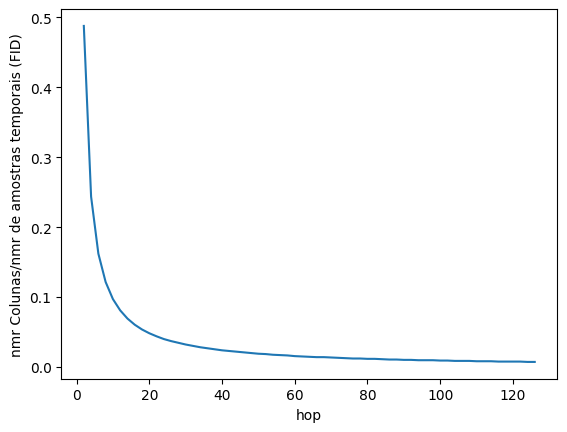

In [8]:
info_concentration = []
for i in range(len(hop_)):
    info_concentration.append(spgram_hop['hop_'+str(hop_[i])][0].shape[2]/gt_fids.shape[1])

plt.plot(hop_,info_concentration)
plt.ylabel('nmr Colunas/nmr de amostras temporais (FID)')
plt.xlabel('hop')

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [8]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(hop_.shape[0]):
    list_of_t_spects.append(spgram_hop['hop_'+str(hop_[i])][-1])
    list_of_ppm_spects.append(spgram_hop['hop_'+str(hop_[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

Projeção no eixo da frequência:

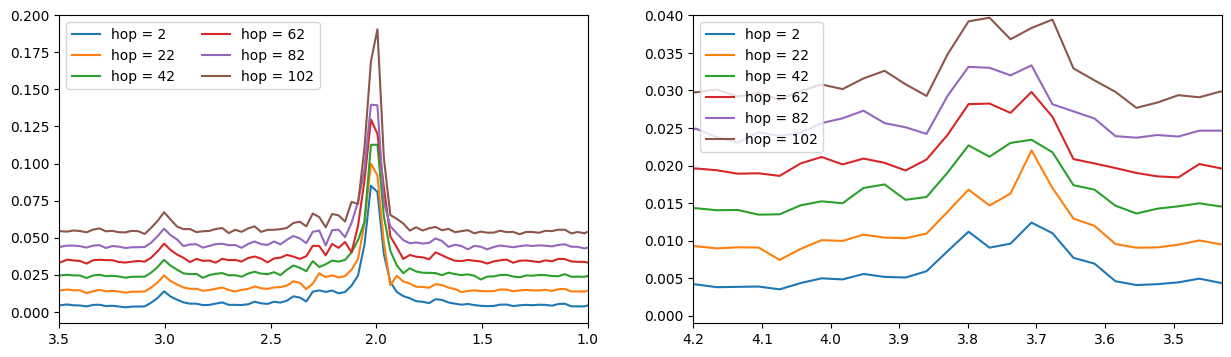

In [14]:
plot_id = np.arange(0,len(hop_),10)
plot_abs = True
fig,ax = plt.subplots(1,2,figsize=(15,4))
for i in range(6):
    if plot_abs == True:
        aux = (np.sum(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])),axis=1))/spgram_hop['hop_'+str(hop_[plot_id[i]])][0].shape[2]
    else:
        aux = (np.sum(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]),axis=1))/spgram_hop['hop_'+str(hop_[plot_id[i]])][0].shape[2]
    ax[0].plot(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2]),aux+0.01*i,label='hop = '+str(hop_[plot_id[i]]))
    ax[1].plot(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2]),aux+0.005*i,label='hop = '+str(hop_[plot_id[i]]))

ax[0].set_xlim(3.5,1)  
ax[1].set_xlim(4.2,3.43)
ax[1].set_ylim(-0.001,0.04)  
ax[0].legend(loc='upper left',ncols=2)
ax[1].legend(loc='upper left')

Medição da FWHM das projeções para os picos de NAA, GABA e Glx:

In [12]:
list_projections_abs = []
list_projections_real = []
fwhm_hop = {}
idx_fwhm = {}
fwhm_hop_real = {}
idx_fwhm_real = {}
for i in range(len(hop_)):
    list_projections_abs.append(np.sum(np.abs(np.real(spgram_hop['hop_'+str(hop_[i])][0])), axis = 2))
    list_projections_real.append(np.sum(np.real(spgram_hop['hop_'+str(hop_[i])][0]), axis = 2))
    idx_fwhm['hop_'+str(hop_[i])] = {}
    idx_fwhm_real['hop_'+str(hop_[i])] = {}

fwhm_hop['NAA'], aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_hop['GABA'], aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_hop['Glx'], aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

fwhm_hop_real['NAA'], aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_hop_real['GABA'], aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_hop_real['Glx'], aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(hop_)):
    idx_fwhm['hop_'+str(hop_[i])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm['hop_'+str(hop_[i])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm['hop_'+str(hop_[i])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real['hop_'+str(hop_[i])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real['hop_'+str(hop_[i])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real['hop_'+str(hop_[i])]['Glx'] = aux_idx_Glx_real[i]

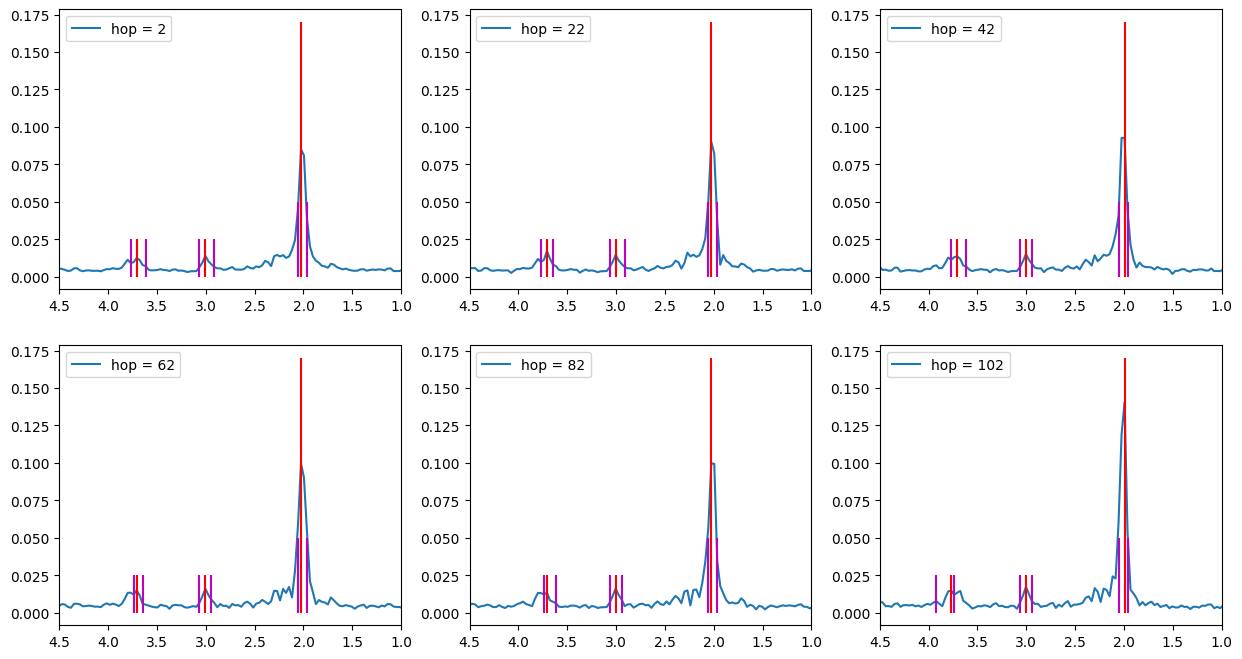

In [15]:
plot_id = np.arange(0,len(hop_),10)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(6):
    ax.flat[i].plot(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2]),(np.sum(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])),axis=1))/spgram_hop['hop_'+str(hop_[plot_id[i]])][0].shape[2],label='hop = '+str(hop_[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['NAA'][0,2])],0,0.17,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['NAA'][0,0])],0,0.05,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['NAA'][0,1])],0,0.05,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['GABA'][0,2])],0,0.025,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['GABA'][0,0])],0,0.025,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['GABA'][0,1])],0,0.025,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['Glx'][0,2])],0,0.025,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['Glx'][0,0])],0,0.025,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm['hop_'+str(hop_[plot_id[i]])]['Glx'][0,1])],0,0.025,color='m')
    ax.flat[i].legend(loc='upper left')

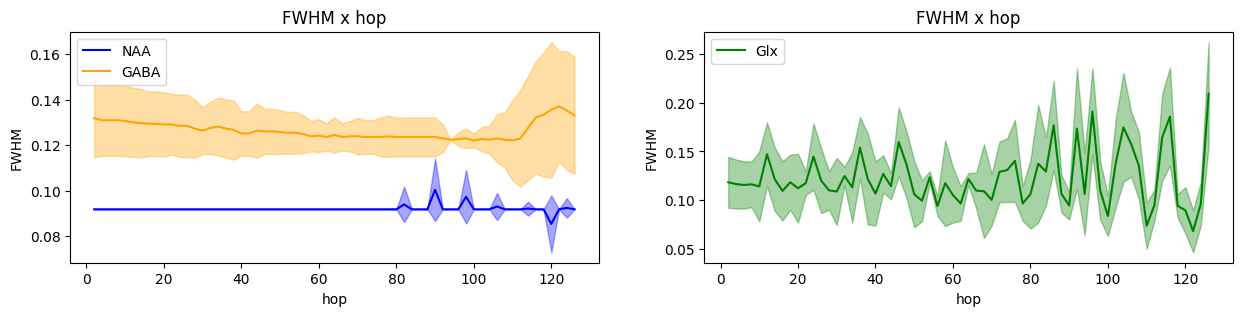

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(hop_,fwhm_hop['NAA']['mean'],label='NAA',color='b')
ax[0].fill_between(hop_, np.array(fwhm_hop['NAA']['mean']) - np.array(fwhm_hop['NAA']['std']), 
                        np.array(fwhm_hop['NAA']['mean']) + np.array(fwhm_hop['NAA']['std']), alpha=0.35, color = 'b')
ax[0].plot(hop_,fwhm_hop['GABA']['mean'],label='GABA',color='orange')
ax[0].fill_between(hop_, np.array(fwhm_hop['GABA']['mean']) - np.array(fwhm_hop['GABA']['std']), 
                        np.array(fwhm_hop['GABA']['mean']) + np.array(fwhm_hop['GABA']['std']), alpha=0.35, color = 'orange')
ax[0].set_title('FWHM x hop')
ax[0].set_xlabel('hop')
ax[0].set_ylabel('FWHM')
ax[0].legend(loc='upper left')
ax[1].plot(hop_,fwhm_hop['Glx']['mean'],label='Glx',color='g')
ax[1].fill_between(hop_, np.array(fwhm_hop['Glx']['mean']) - np.array(fwhm_hop['Glx']['std']), 
                        np.array(fwhm_hop['Glx']['mean']) + np.array(fwhm_hop['Glx']['std']), alpha=0.35, color = 'g')
ax[1].set_title('FWHM x hop')
ax[1].set_xlabel('hop')
ax[1].set_ylabel('FWHM')
ax[1].legend(loc='upper left')

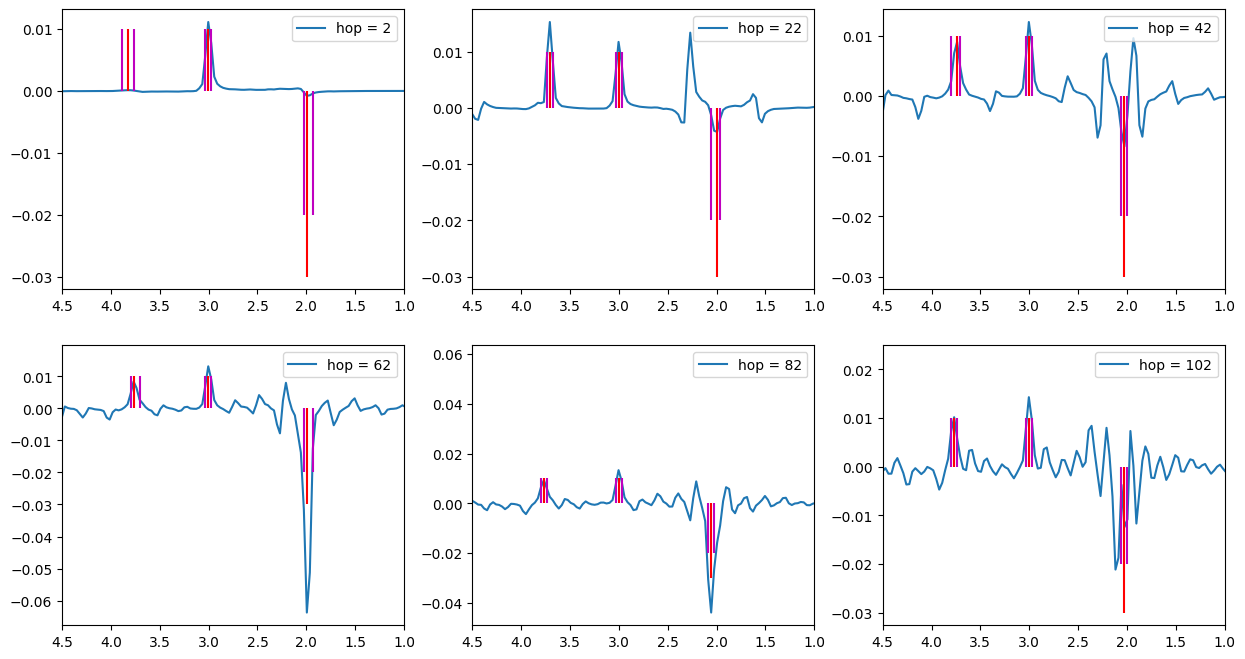

In [16]:
plot_id = np.arange(0,len(hop_),10)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(6):
    ax.flat[i].plot(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2]),(np.sum(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]),axis=1))/spgram_hop['hop_'+str(hop_[plot_id[i]])][0].shape[2],label='hop = '+str(hop_[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['NAA'][0,2])],-0.03,0,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['NAA'][0,0])],-0.02,0,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['NAA'][0,1])],-0.02,0,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['GABA'][0,2])],0,0.01,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['GABA'][0,0])],0,0.01,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['GABA'][0,1])],0,0.01,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['Glx'][0,2])],0,0.01,color='r')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['Glx'][0,0])],0,0.01,color='m')
    ax.flat[i].vlines(np.flip(spgram_hop['hop_'+str(hop_[plot_id[i]])][2])[int(idx_fwhm_real['hop_'+str(hop_[plot_id[i]])]['Glx'][0,1])],0,0.01,color='m')
    ax.flat[i].legend(loc='upper right')

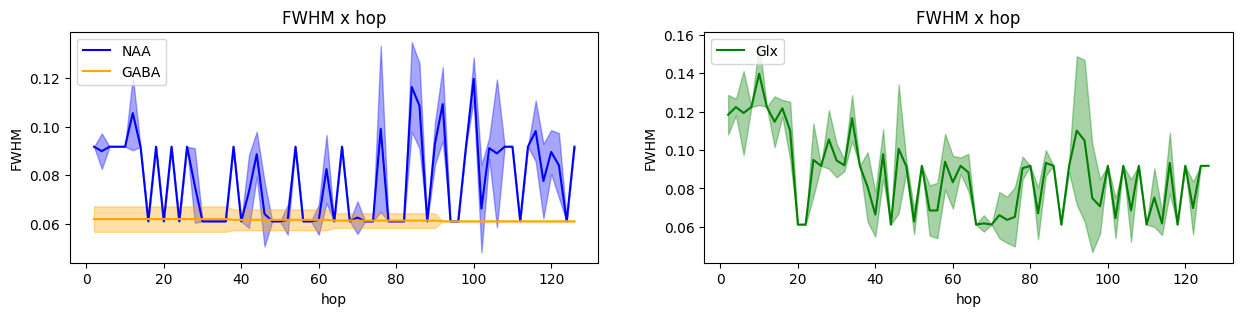

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(hop_,fwhm_hop_real['NAA']['mean'],label='NAA',color='b')
ax[0].fill_between(hop_, np.array(fwhm_hop_real['NAA']['mean']) - np.array(fwhm_hop_real['NAA']['std']), 
                        np.array(fwhm_hop_real['NAA']['mean']) + np.array(fwhm_hop_real['NAA']['std']), alpha=0.35, color = 'b')
ax[0].plot(hop_,fwhm_hop_real['GABA']['mean'],label='GABA',color='orange')
ax[0].fill_between(hop_, np.array(fwhm_hop_real['GABA']['mean']) - np.array(fwhm_hop_real['GABA']['std']), 
                        np.array(fwhm_hop_real['GABA']['mean']) + np.array(fwhm_hop_real['GABA']['std']), alpha=0.35, color = 'orange')
ax[0].set_title('FWHM x hop')
ax[0].set_xlabel('hop')
ax[0].set_ylabel('FWHM')
ax[0].legend(loc='upper left')
ax[1].plot(hop_,fwhm_hop_real['Glx']['mean'],label='Glx',color='g')
ax[1].fill_between(hop_, np.array(fwhm_hop_real['Glx']['mean']) - np.array(fwhm_hop_real['Glx']['std']), 
                        np.array(fwhm_hop_real['Glx']['mean']) + np.array(fwhm_hop_real['Glx']['std']), alpha=0.35, color = 'g')
ax[1].set_title('FWHM x hop')
ax[1].set_xlabel('hop')
ax[1].set_ylabel('FWHM')
ax[1].legend(loc='upper left')

Espectrogramas concatenados:

In [16]:
aux_concat = (np.arange(4,len(hop_),6)).tolist()
spgram_hop_concat = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop,list_time_idx=idx_time_0d4,fid_idx_plot=0)

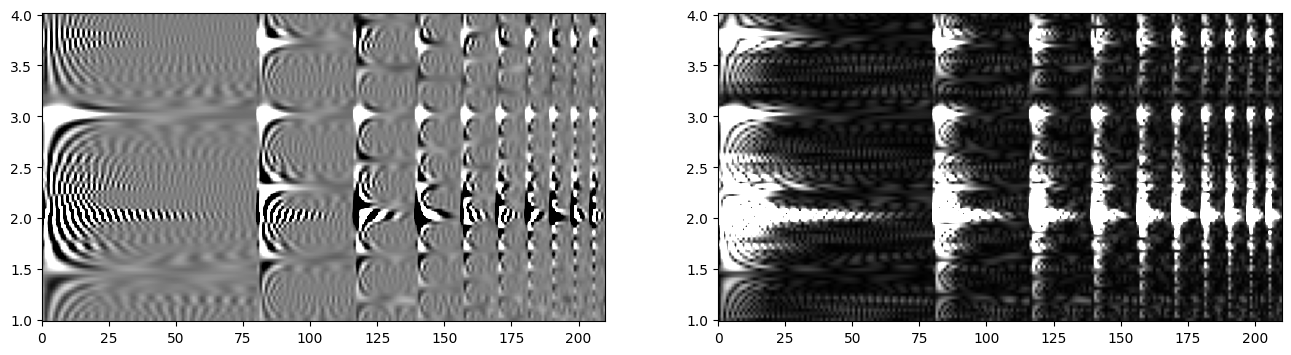

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(np.real(spgram_hop_concat[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat.shape[-1],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax[1].imshow(np.abs(np.real(spgram_hop_concat[idx_freq_1ppm[0]:idx_freq_4ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_hop_concat.shape[-1],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))

O padrão de listras das imagens muda com hop?

In [20]:
zcr_ = funcstud.get_zcr_for_relevant_peaks_for_different_spgrams(spgram_dict=spgram_hop,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4)

<StemContainer object of 3 artists>

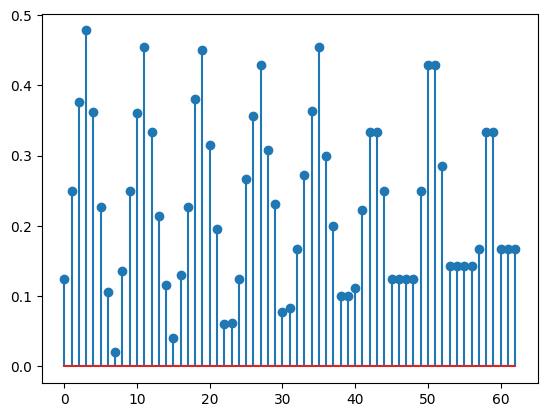

In [19]:
plt.stem(zcr_['NAA']['mean'],label='NAA')


In [20]:
aux_concat = (np.arange(3,12)).tolist()
spgram_hop_concat_for_zcr_1 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop,list_time_idx=idx_time_0d4,fid_idx_plot=0)
aux_concat = (np.arange(11,20)).tolist()
spgram_hop_concat_for_zcr_2 = funcstud.concatenate_different_hop(list_hop_all=hop_,list_hop_concat_idx=aux_concat,spgram_dict=spgram_hop,list_time_idx=idx_time_0d4,fid_idx_plot=0)

Text(0.5, 1.0, 'Concatenação de Re(STFT(gt)) para hops Consecutivos')

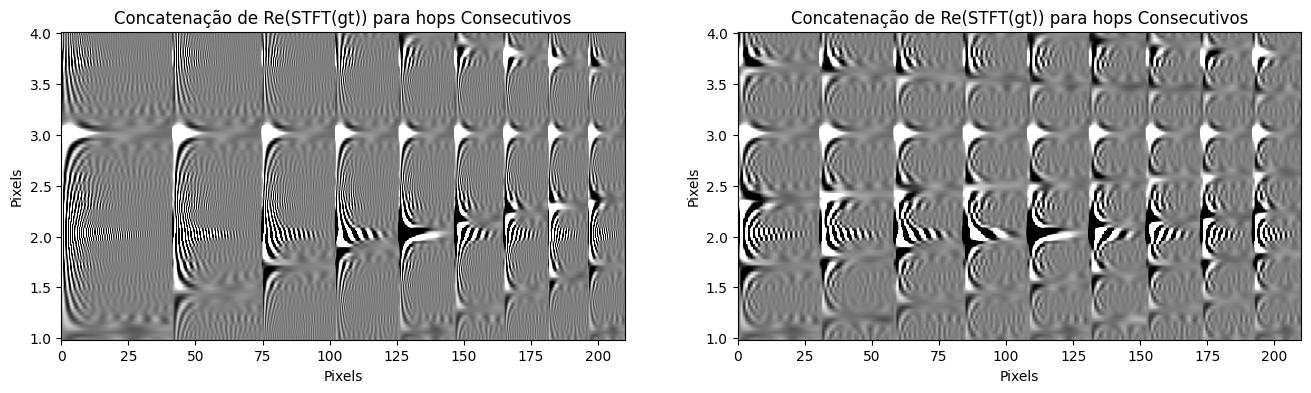

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].imshow(np.real(spgram_hop_concat_for_zcr_1[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat.shape[-1],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax[0].set_xlabel('Pixels')
ax[0].set_ylabel('Pixels')
ax[0].set_title('Concatenação de Re(STFT(gt)) para hops Consecutivos')
ax[1].imshow(np.real(spgram_hop_concat_for_zcr_2[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat.shape[-1],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax[1].set_xlabel('Pixels')
ax[1].set_ylabel('Pixels')
ax[1].set_title('Concatenação de Re(STFT(gt)) para hops Consecutivos')

Text(0, 0.5, 'Amplitude linha de Glx')

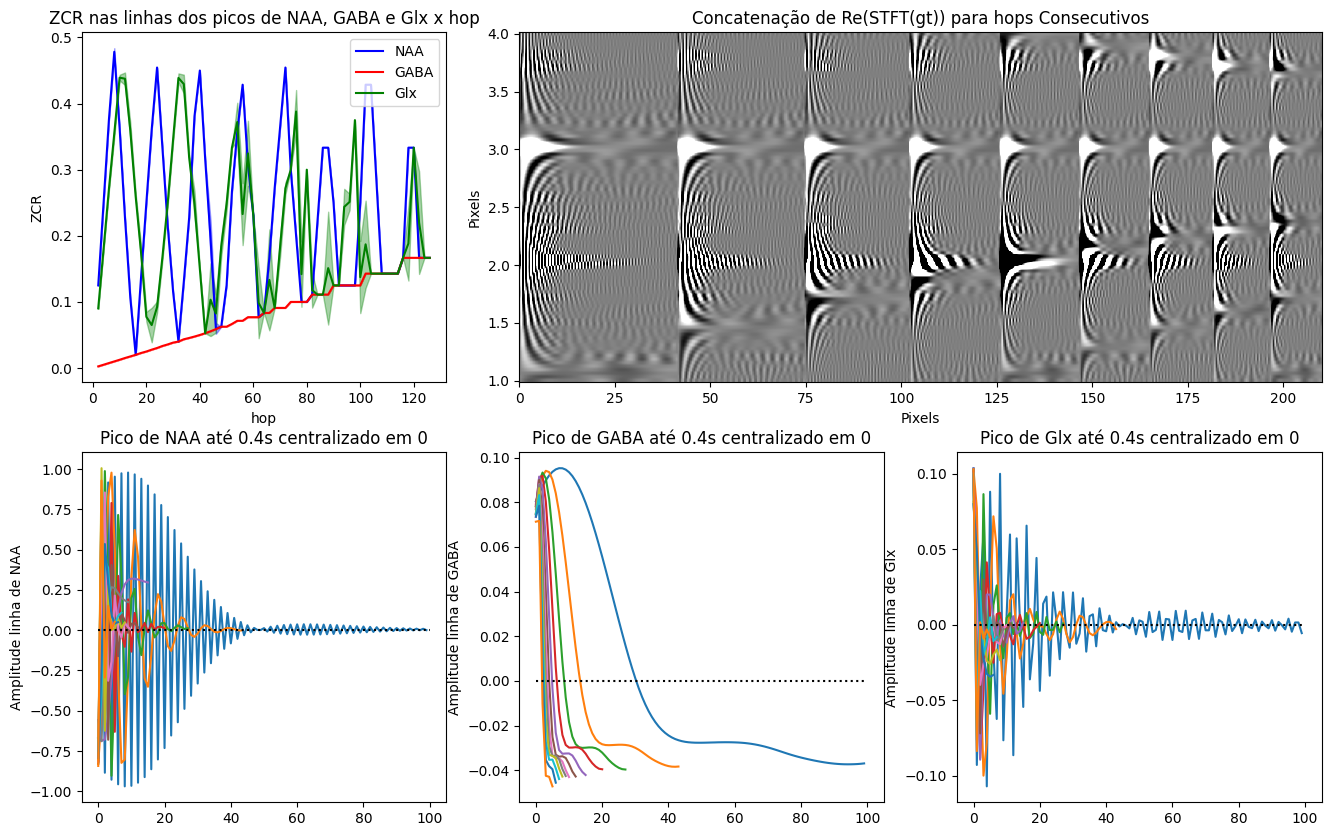

In [22]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1:]) 
ax3 = fig.add_subplot(gs[1, 0])    
ax4 = fig.add_subplot(gs[1, 1]) 
ax5 = fig.add_subplot(gs[1, 2])

ax1.plot(hop_,zcr_['NAA']['mean'],color='b',label='NAA')
#ax1.plot(hop_,np.convolve(zcr_['NAA'],(1/6)*np.ones(6),'same'),color='b',linestyle='dotted')
ax1.fill_between(hop_, np.array(zcr_['NAA']['mean']) - np.array(zcr_['NAA']['std']), 
                        np.array(zcr_['NAA']['mean']) + np.array(zcr_['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(hop_,zcr_['GABA']['mean'],color='r',label='GABA')
ax1.fill_between(hop_, np.array(zcr_['GABA']['mean']) - np.array(zcr_['GABA']['std']), 
                        np.array(zcr_['GABA']['mean']) + np.array(zcr_['GABA']['std']), alpha=0.35, color = 'r')
ax1.plot(hop_,zcr_['Glx']['mean'],color='g',label='Glx')
#ax1.plot(hop_,np.convolve(zcr_['Glx'],(1/6)*np.ones(6),'same'),color='g',linestyle='dotted')
ax1.fill_between(hop_, np.array(zcr_['Glx']['mean']) - np.array(zcr_['Glx']['std']), 
                        np.array(zcr_['Glx']['mean']) + np.array(zcr_['Glx']['std']), alpha=0.35, color = 'g')
ax1.legend(loc='upper right')
ax1.set_title('ZCR nas linhas dos picos de NAA, GABA e Glx x hop')
ax1.set_ylabel('ZCR')
ax1.set_xlabel('hop')

ax2.imshow(np.real(spgram_hop_concat_for_zcr_1[idx_freq_1ppm[0]:idx_freq_4ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_hop_concat.shape[-1],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_hop['hop_'+str(hop_[0])][2])[idx_freq_4ppm[0]]))
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Pixels')
ax2.set_title('Concatenação de Re(STFT(gt)) para hops Consecutivos')

for i in range(3,len(hop_),5):
    ax3.plot(np.real(spgram_hop['hop_'+str(hop_[i])][0][0,idx_freq_NAA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop['hop_'+str(hop_[i])][0][:,idx_freq_NAA[i],:idx_time_0d4[i]]),axis=1)[0])
    ax4.plot(np.real(spgram_hop['hop_'+str(hop_[i])][0][0,idx_freq_GABA[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop['hop_'+str(hop_[i])][0][:,idx_freq_GABA[i],:idx_time_0d4[i]]),axis=1)[0])
    ax5.plot(np.real(spgram_hop['hop_'+str(hop_[i])][0][0,idx_freq_Glx[i],:idx_time_0d4[i]])-np.mean(np.real(spgram_hop['hop_'+str(hop_[i])][0][:,idx_freq_Glx[i],:idx_time_0d4[i]]),axis=1)[0])
ax3.hlines(0,0,100,color='black',linestyle='dotted')
ax4.hlines(0,0,100,color='black',linestyle='dotted')
ax5.hlines(0,0,100,color='black',linestyle='dotted')
ax3.set_title('Pico de NAA até 0.4s centralizado em 0')
ax3.set_ylabel('Amplitude linha de NAA')
ax4.set_title('Pico de GABA até 0.4s centralizado em 0')
ax4.set_ylabel('Amplitude linha de GABA')
ax5.set_title('Pico de Glx até 0.4s centralizado em 0')
ax5.set_ylabel('Amplitude linha de Glx')

Get some statistical insights:

First, let's divide the image in sections of ppm:

In [23]:
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]
idx_time_list_sup = []
for i in range(len(hop_)):
    idx_time_list_sup.append([idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],idx_time_0d4[i],
                            idx_time_0d05[i],idx_time_0d05[i],
                            idx_time_0d4[i],idx_time_0d05[i],idx_time_0d05[i]])
max_sec, mean_sec, std_sec = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_hop, part='real', sections=sections, idx_time_list_sup=idx_time_list_sup)

idx_time_list_inf = []
for i in range(len(hop_)):
    idx_time_list_inf.append([idx_time_0d6[i]])
max_sec_aux, mean_sec_aux, std_sec_aux = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_hop, part='real', sections=[1,4], idx_time_list_inf=idx_time_list_inf)
max_sec['residual'] = max_sec_aux['1:4']
mean_sec['residual'] = mean_sec_aux['1:4']
std_sec['residual'] = std_sec_aux['1:4']

Observe how the maximum value changes in every region with hop:

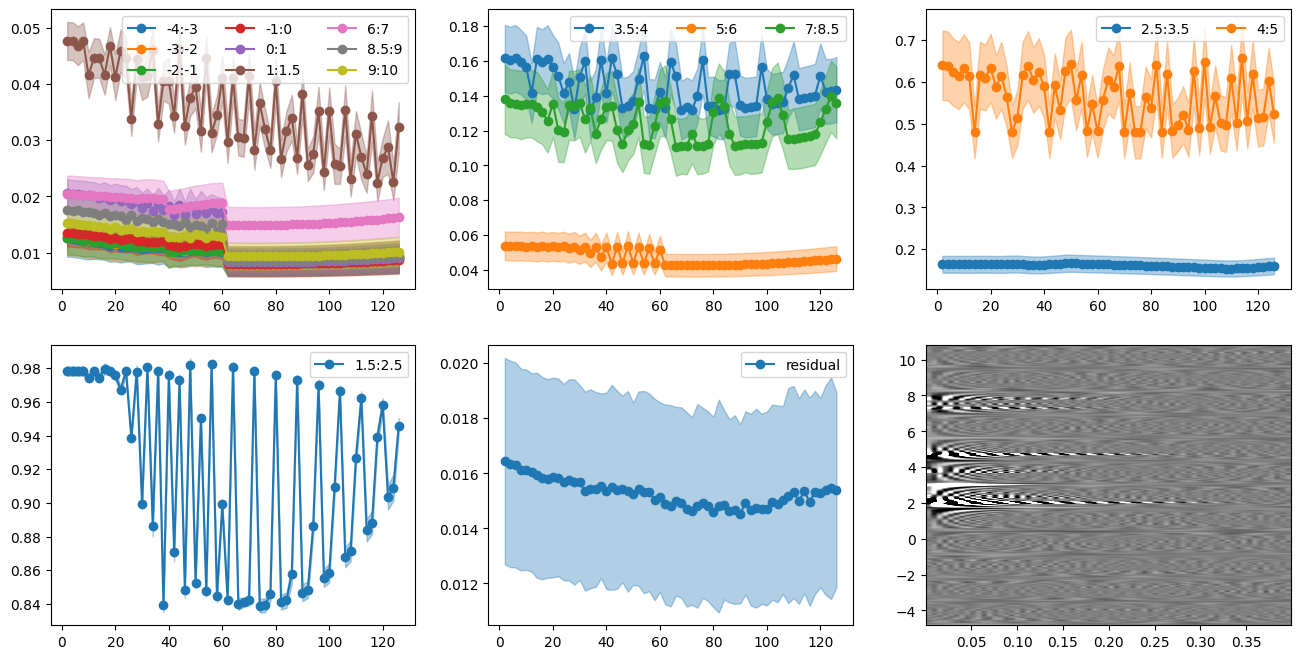

In [24]:
fig,ax = plt.subplots(2,3,figsize=(16,8))
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]

first_plot = [0,1,2,3,4,5,11,13,14]
second_plot = [8,10,12]
third_plot = [7,9]
fourth_plot = [6]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

for j in range(len(first_plot)):
        aux = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1])]['std']
        ax.flat[0].plot(hop_,aux,label =str(sections[first_plot[j]])+':'+str(sections[first_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[0].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(second_plot)):
        aux = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1])]['std']
        ax.flat[1].plot(hop_,aux,label =str(sections[second_plot[j]])+':'+str(sections[second_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[1].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(third_plot)):
        aux = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1])]['std']
        ax.flat[2].plot(hop_,aux,label =str(sections[third_plot[j]])+':'+str(sections[third_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[2].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
for j in range(len(fourth_plot)):
        aux = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['mean']
        aux_std = max_sec[str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1])]['std']
        ax.flat[3].plot(hop_,aux,label =str(sections[fourth_plot[j]])+':'+str(sections[fourth_plot[j]+1]),marker='o',color=colors[j])
        ax.flat[3].fill_between(hop_, np.array(aux) - np.array(aux_std), 
                        np.array(aux) + np.array(aux_std), alpha=0.35, color=colors[j])
ax.flat[4].plot(hop_,max_sec['residual']['mean'],label='residual',marker='o')
ax.flat[4].fill_between(hop_, np.array(max_sec['residual']['mean']) - np.array(max_sec['residual']['std']), 
                        np.array(max_sec['residual']['mean']) + np.array(max_sec['residual']['std']), alpha=0.35, color=colors[j])
for i in range(5):
    ax.flat[i].legend(loc='upper right',ncols=3)
    
ax.flat[5].imshow(np.real(spgram_hop['hop_'+str(hop_[5])][0][0,:,:idx_time_0d4[5]]), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04,
            extent = (spgram_hop['hop_'+str(hop_[5])][-1][0],spgram_hop['hop_'+str(hop_[5])][-1][idx_time_0d4[5]],
                     np.flip(spgram_hop['hop_'+str(hop_[5])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[5])][2])[-1]))

Using these values we can segment the regions of the image:

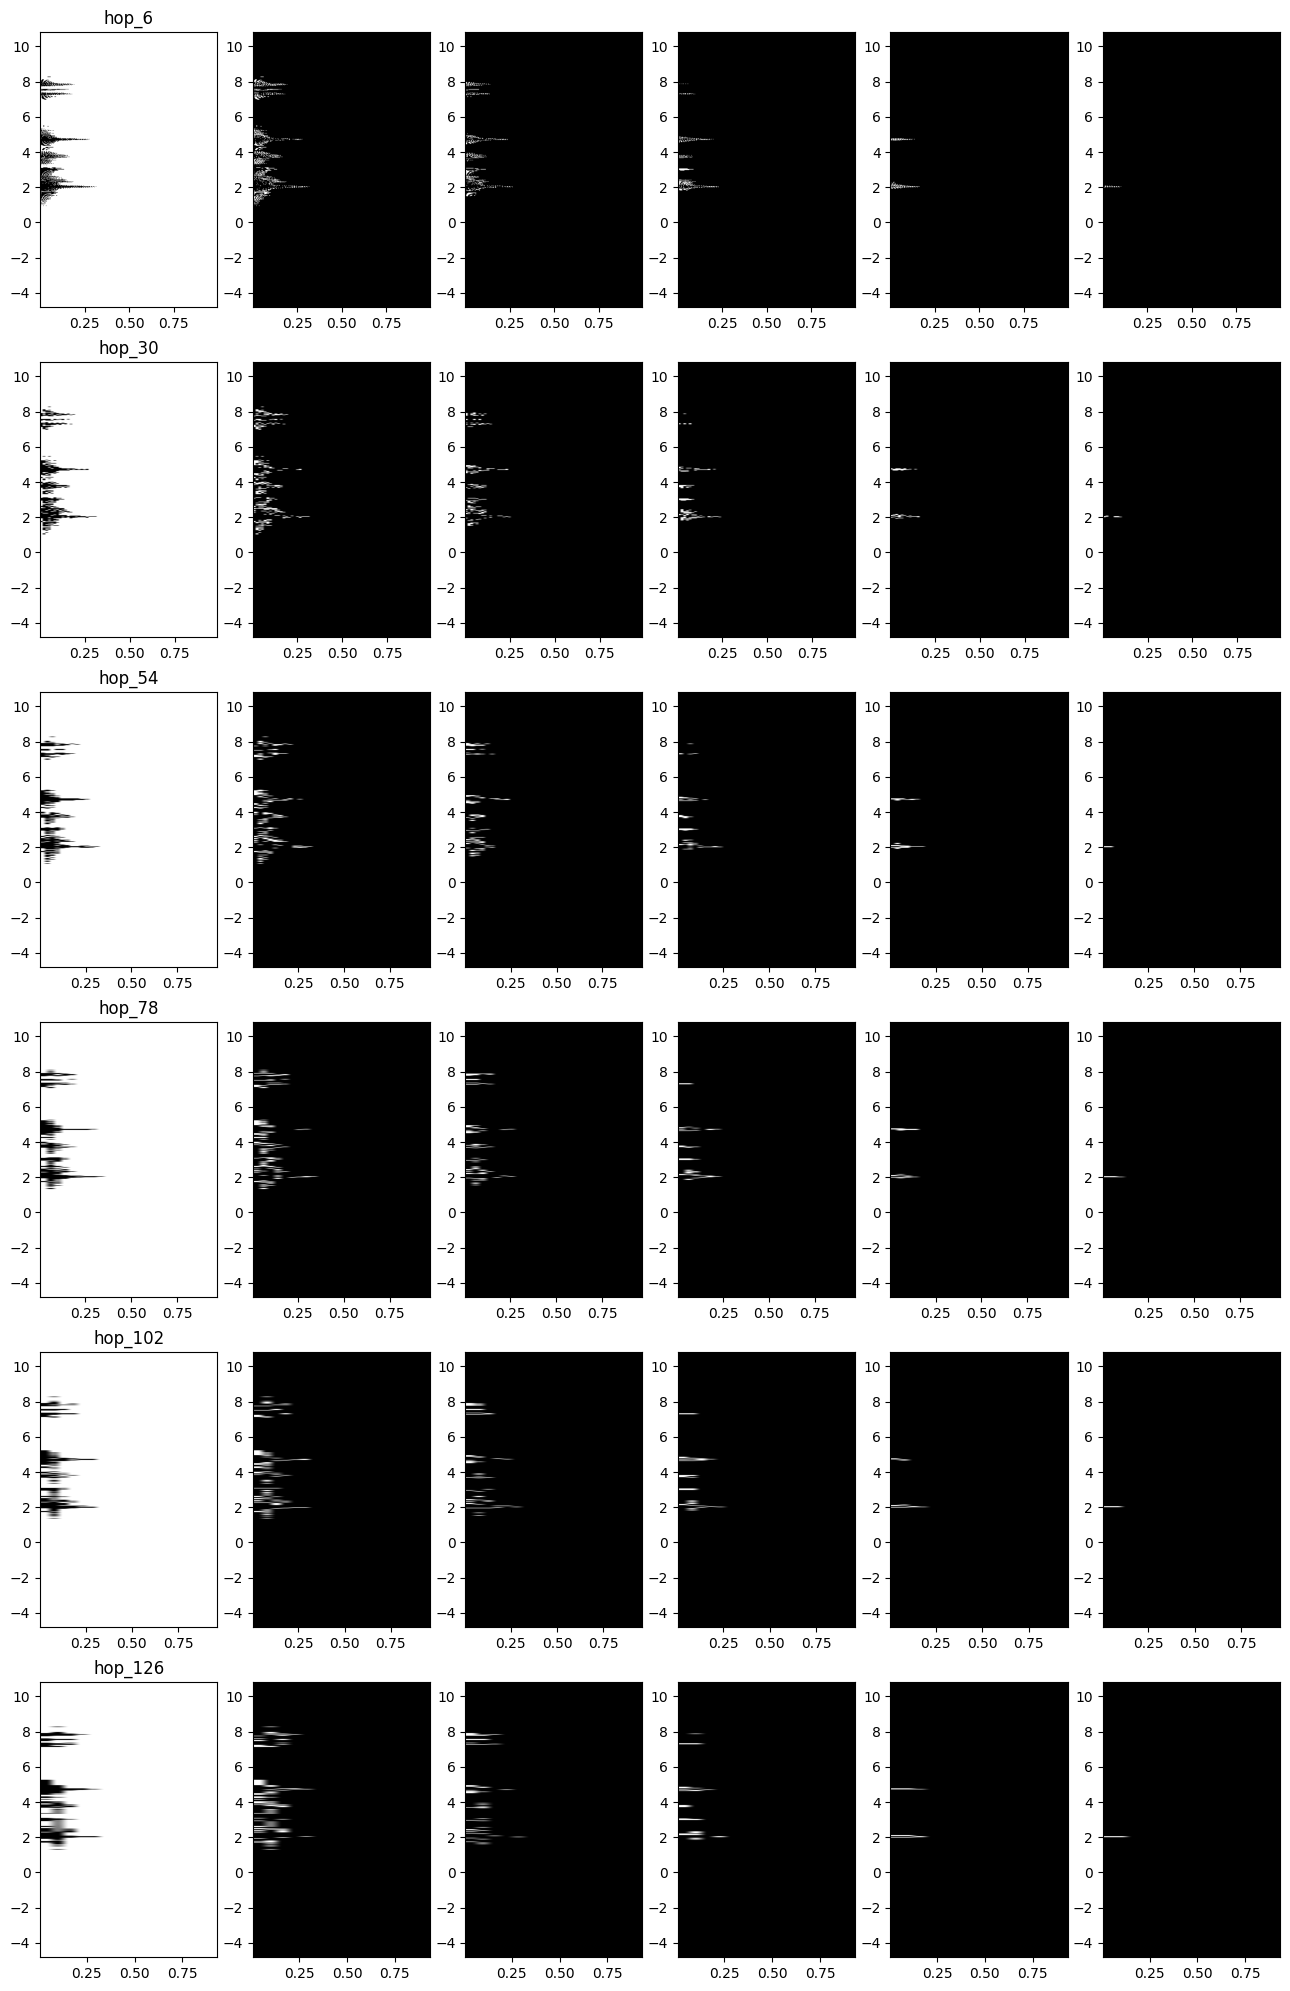

In [31]:
fig,ax = plt.subplots(6,6,figsize=(16,25))
plot_id = np.arange(2,len(hop_),12)
row = 0
for idx in range(len(plot_id)):
    seg_res = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.02
    seg_res2 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.04).astype('int')
    seg_res3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.08).astype('int')
    seg_res4 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.2).astype('int')
    seg_res5 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 0.6).astype('int')
    seg_res6 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) > 0.6).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[idx]])][0][0,:,:])) < 1).astype('int')
    ax.flat[6*row].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = (spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][0],spgram_hop['hop_'+str(hop_[plot_id[idx]])][-1][-1],
                    np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[0],np.flip(spgram_hop['hop_'+str(hop_[plot_id[idx]])][2])[-1]))
    ax.flat[6*row].set_title('hop_'+str(hop_[plot_id[idx]]))
    row = row+1

% of pixels in each segmented region x hop value:

In [28]:
regions = [0.02,0.04,0.08,0.2,0.6]
hist, bins, bins_centered, qntty_percent_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_hop,nbins=5000,part='real',regions=regions,normalized=True)
hist_absolute, bins_absolute, bins_centered_absolute, qntty_absolute_regions = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=spgram_hop,nbins=5000,part='real',regions=regions,normalized=False)

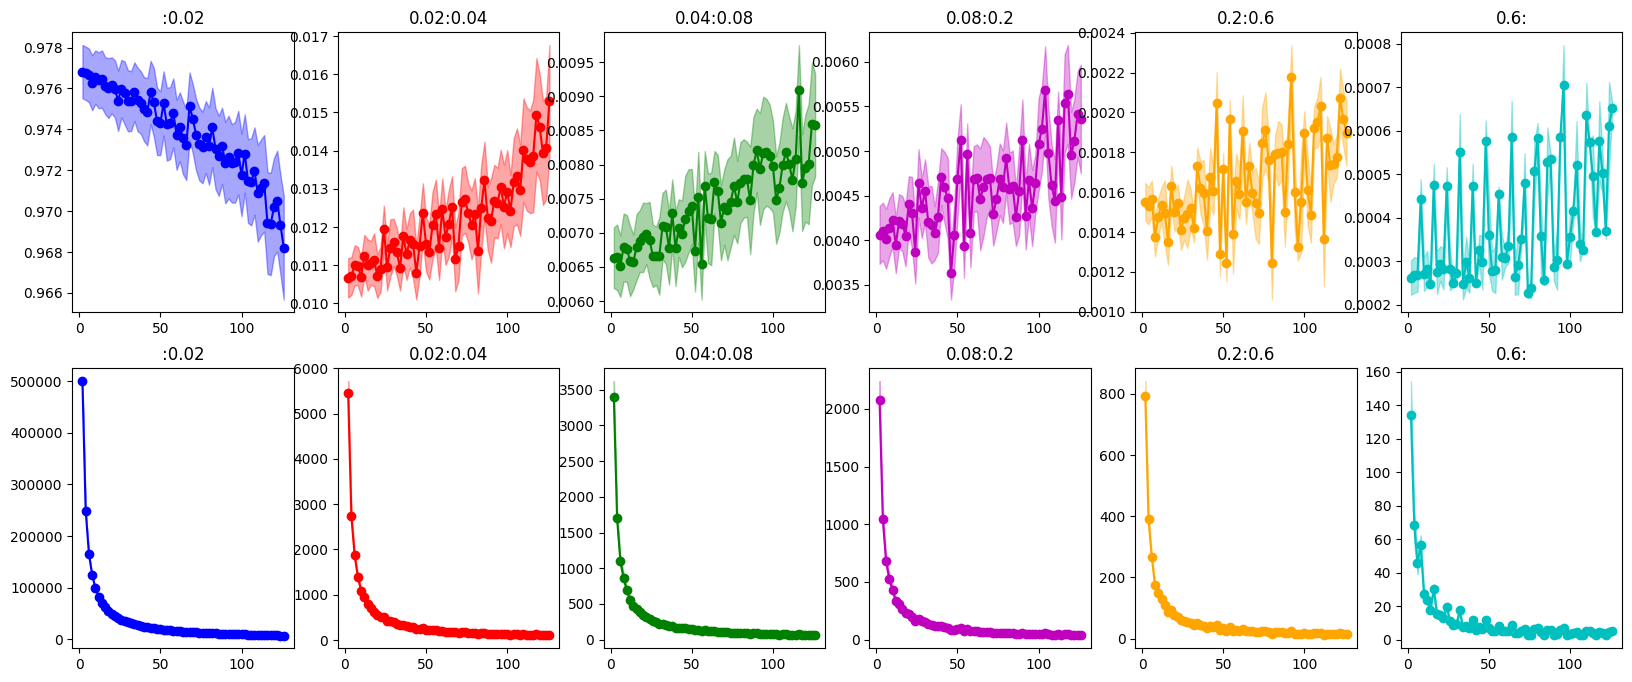

In [33]:
colors = ['b','r','g','m','orange','c']
fig,ax = plt.subplots(2,6,figsize=(20,8))
for i in range(len(list(qntty_percent_regions.keys()))):
    aux = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['mean'])
    aux_std = np.array(qntty_percent_regions[list(qntty_percent_regions.keys())[i]]['std'])

    aux_absolute = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['mean'])
    aux_absolute_std = np.array(qntty_absolute_regions[list(qntty_absolute_regions.keys())[i]]['std'])
    ax[0,i].plot(hop_,aux,marker='o',color=colors[i])
    ax[0,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[i])
    ax[0,i].set_title(list(qntty_percent_regions.keys())[i])
    ax[1,i].plot(hop_,aux_absolute,marker='o',color=colors[i])
    ax[1,i].fill_between(hop_, aux_absolute - aux_absolute_std, 
                       aux_absolute + aux_absolute_std, alpha=0.35, color = colors[i])
    ax[1,i].set_title(list(qntty_absolute_regions.keys())[i])

Stats of each segmented region x hop:

In [30]:
stats_per_region = funcstud.stats_per_segmented_regions_for_different_spgrams(regions_threshold=regions,spgram_dict=spgram_hop, part='real')

In [31]:
stats_global = utils.stats_global_for_different_spgrams(spgram_dict=spgram_hop, part='part')

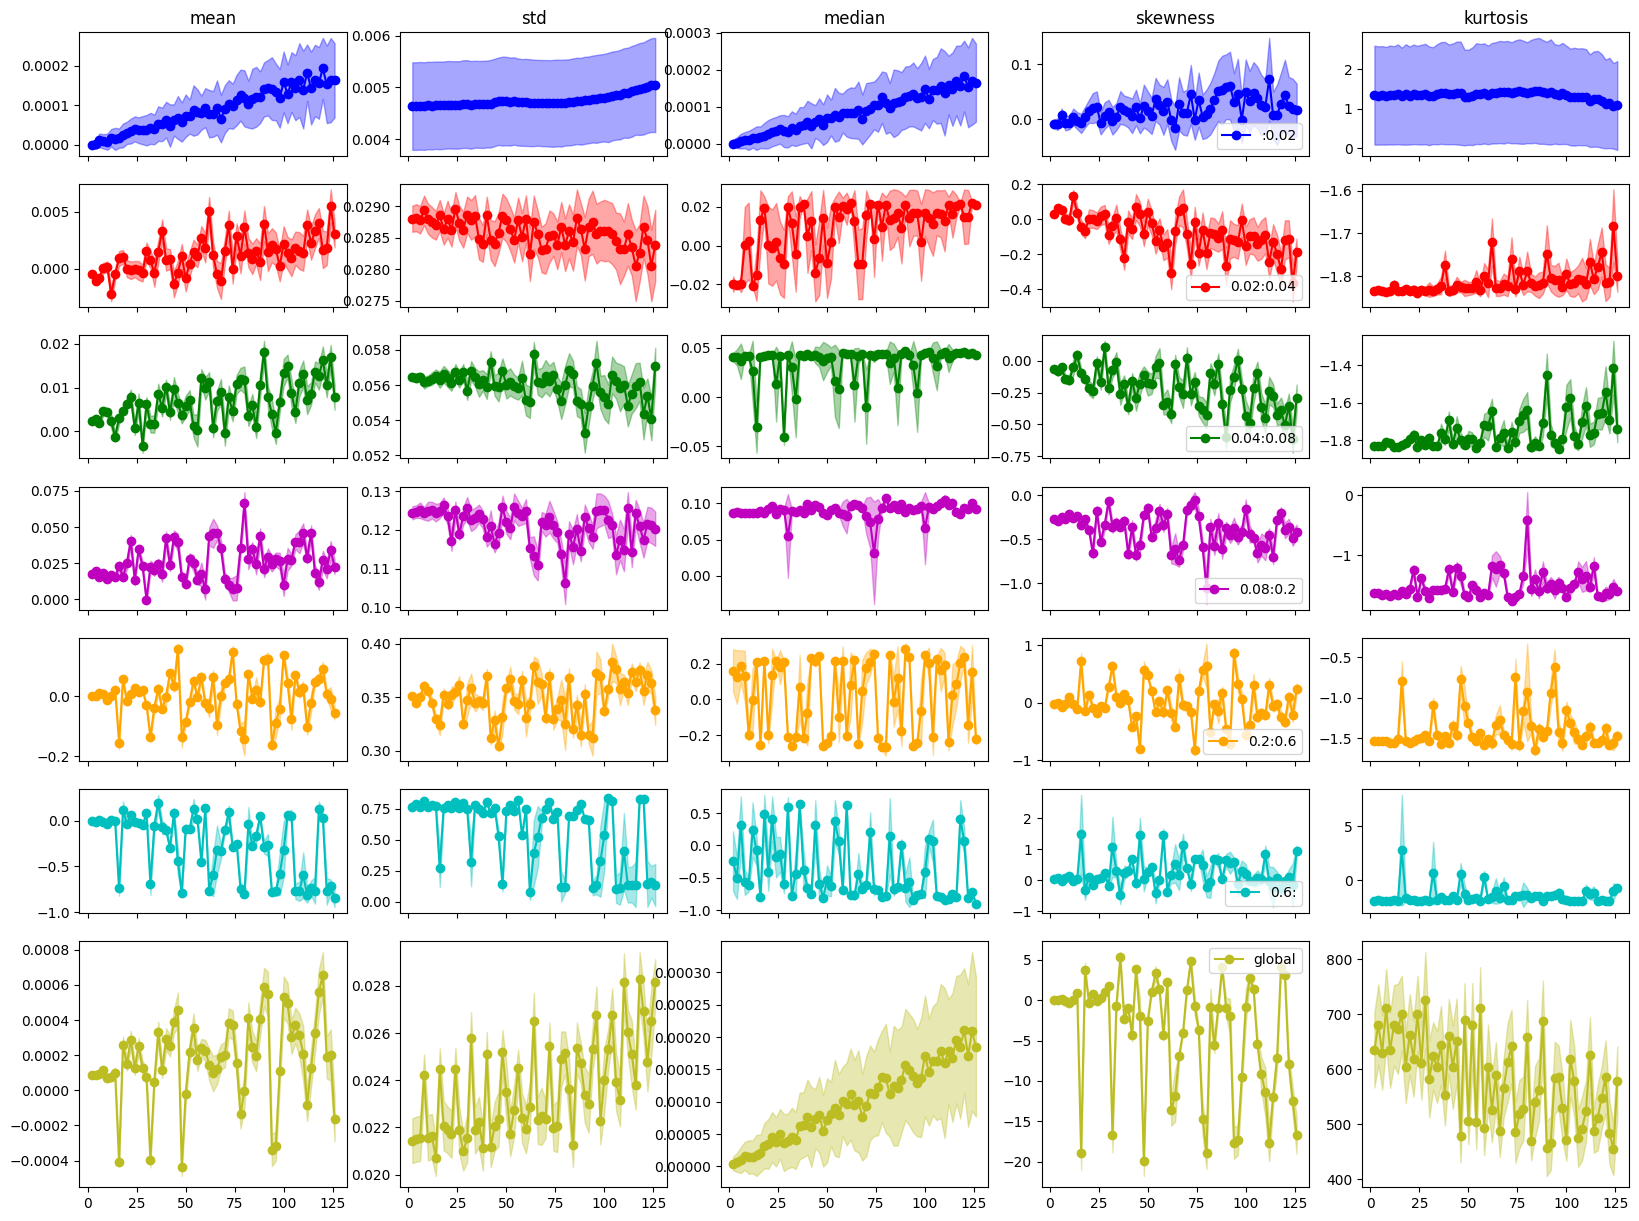

In [12]:
fig,ax = plt.subplots(7,5,figsize=(20,15), sharex='col', height_ratios=[1, 1, 1, 1, 1, 1, 2])

stat_name = ['mean','std','median','skewness','kurtosis']
colors = ['b','r','g','m','orange','c']
for j in range(len(stat_name)):
    for i in range(len(list(stats_per_region[stat_name[j]].keys()))):
        aux = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['mean'])
        aux_std = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['std'])
        ax[i,j].plot(hop_,aux,marker='o',color=colors[i],label=list(stats_per_region[stat_name[j]].keys())[i])
        ax[i,j].fill_between(hop_, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        if i == 0:
            ax[i,j].set_title(stat_name[j])
        if j == 3:
            ax[i,j].legend(loc='lower right')
colors = ['#bcbd22']
for i in range(len(stat_name)):
    aux = np.array(stats_global[stat_name[i]]['mean'])
    aux_std = np.array(stats_global[stat_name[i]]['std'])
    ax[6,i].plot(hop_,aux,marker='o',color=colors[0],label="global")
    ax[6,i].fill_between(hop_, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[0])
    if i == 3:
        ax[6,i].legend(loc='upper right')
plt.show()

Checking visually the metrics obtained:

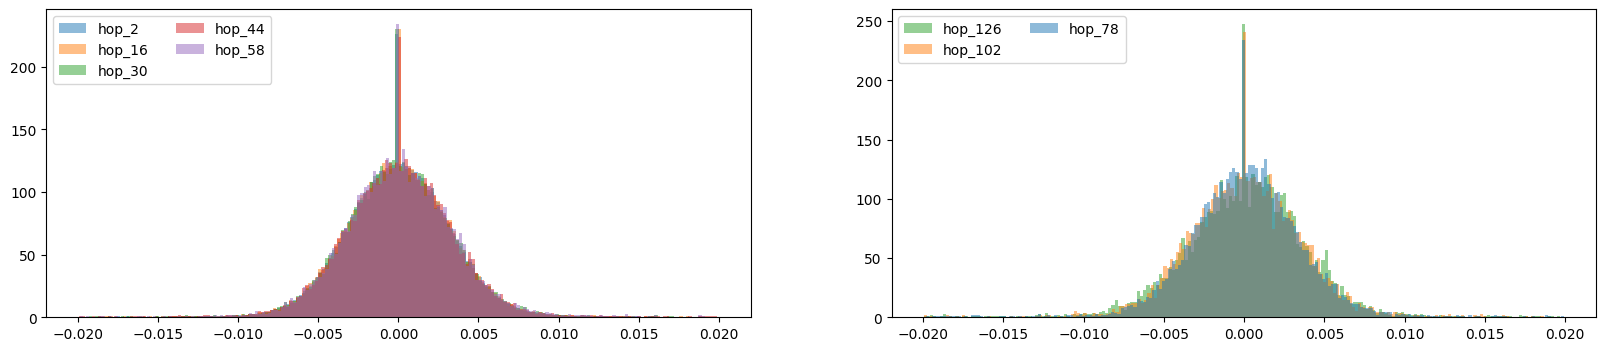

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,4))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_id = np.arange(0,34,7)
for i in (range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.02
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[0].legend(loc='upper left',ncols=2)

plot_id = [38,50,-1]
for i in reversed(range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.02
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[1].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[1].legend(loc='upper left',ncols=2)

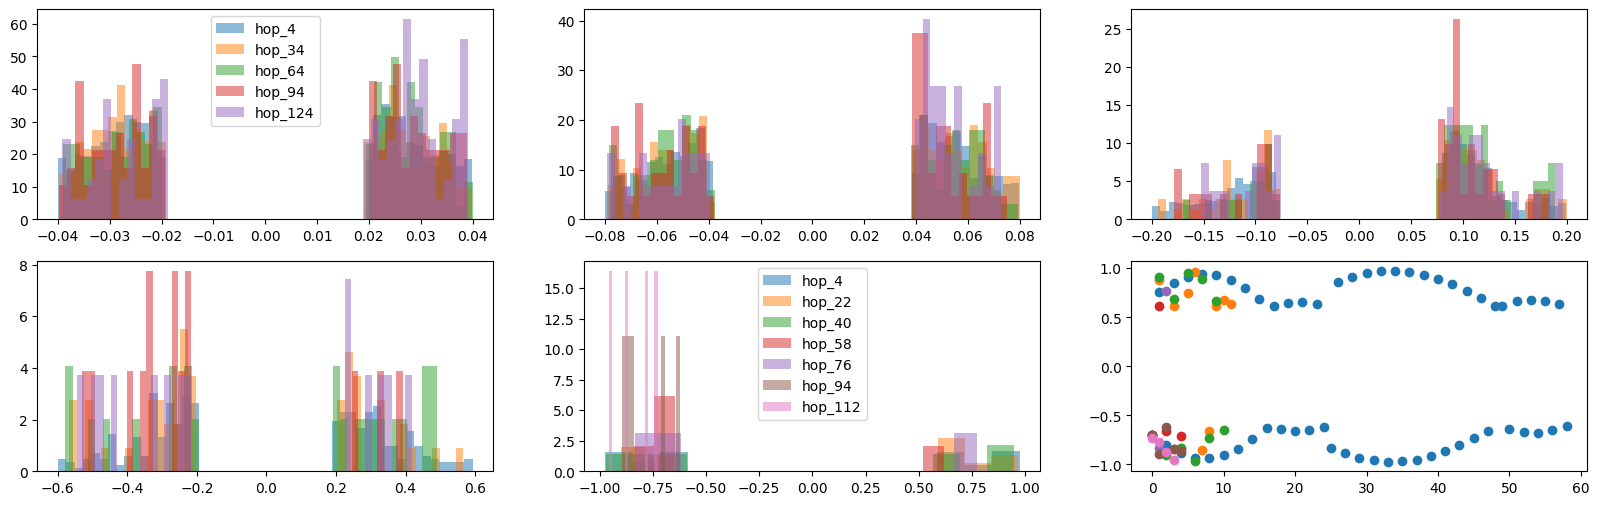

In [69]:
fig,ax = plt.subplots(2,3,figsize=(20,6))
plot_id = np.arange(1,len(hop_),15)
for i in (range(len(plot_id))):
    seg_2 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.04).astype('int')
    aux = np.real(seg_2*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[0].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[1].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_4 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.2).astype('int')
    aux = np.real(seg_4*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[2].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_5 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.6).astype('int')
    aux = np.real(seg_5*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[3].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    

plot_id = np.arange(1,len(hop_),9)
for i in (range(len(plot_id))):
    seg_6 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.6).astype('int')
    aux = np.real(seg_6*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[4].hist(aux_no_zeros,15,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    ax.flat[5].scatter(np.arange(aux_no_zeros.shape[0]),aux_no_zeros,marker='o')

ax.flat[0].legend(loc='upper center')
ax.flat[4].legend(loc='upper center')

In [16]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (kurt/std) for region ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_per_region['kurtosis'][reg]['mean']))

test hypothesis (kurt/std) for region  :0.02 : PearsonRResult(statistic=-0.7809761784358411, pvalue=4.371297980073226e-14)
test hypothesis (kurt/std) for region  0.02:0.04 : PearsonRResult(statistic=-0.6949126432053078, pvalue=2.644818148648319e-10)
test hypothesis (kurt/std) for region  0.04:0.08 : PearsonRResult(statistic=-0.7336946068214941, pvalue=7.92507286758566e-12)
test hypothesis (kurt/std) for region  0.08:0.2 : PearsonRResult(statistic=-0.8221107767199223, pvalue=1.4669394717950702e-16)
test hypothesis (kurt/std) for region  0.2:0.6 : PearsonRResult(statistic=-0.48246634932010074, pvalue=6.220293340268869e-05)
test hypothesis (kurt/std) for region  0.6: : PearsonRResult(statistic=-0.345177415823851, pvalue=0.0055951797995437424)


In [17]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (skew/mean) for region ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_per_region['skewness'][reg]['mean']))

test hypothesis (skew/mean) for region  :0.02 : PearsonRResult(statistic=0.6622543848514901, pvalue=3.398613953696157e-09)
test hypothesis (skew/mean) for region  0.02:0.04 : PearsonRResult(statistic=-0.9883226823675461, pvalue=1.4799486452000583e-51)
test hypothesis (skew/mean) for region  0.04:0.08 : PearsonRResult(statistic=-0.9886564537373446, pvalue=6.140497898265586e-52)
test hypothesis (skew/mean) for region  0.08:0.2 : PearsonRResult(statistic=-0.9763732150736196, pvalue=2.6939333846962635e-42)
test hypothesis (skew/mean) for region  0.2:0.6 : PearsonRResult(statistic=-0.9544189211036425, pvalue=9.909540682535749e-34)
test hypothesis (skew/mean) for region  0.6: : PearsonRResult(statistic=-0.383198346320572, pvalue=0.0019358999409541642)


In [71]:
plot_id = np.arange(len(hop_))
for i in (range(len(plot_id))):
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.04).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    hist_aux,bins_aux = np.histogram(aux_no_zeros,50,density = True)
    idx = []
    for k in range(len(hist_aux)):
        if hist_aux[k] == 0:
            idx.append(k)
    print(np.sum(hist_aux[:idx[0]]),np.sum(hist_aux[idx[-1]+1:]))

146.0512106733166 166.59631538173497
145.04256996522997 167.6240479238886
148.60892871291367 164.16487448018975
145.82400760305302 166.9641743857441
140.04702126685675 173.49108604700166
142.90527214857306 169.86853104453027
158.21870218492901 154.50464814302924
147.64993935285008 165.78238804530537
144.24283776473095 168.5955246600752
137.50160902131182 179.80979641248464
131.60495767565598 182.72423875628272
155.1047343114585 157.73362811334766
132.80681334403997 180.8433202982672
44.99674907455824 148.48927194604212
135.99763550262736 182.4358525035246
154.0574913017336 160.6836199598727
147.15499870006732 167.92982204595918
120.77936777160235 192.0589946532037
137.62982832663295 177.22197072196565
128.93943167828752 188.96296021817983
146.43456950868267 170.1225145762637
127.26635000214526 190.89952500321783
139.62278412670497 181.26466711186256
154.87581452381843 162.75085594028366
141.2396320934993 178.40795632863077
17.809917178230535 178.09917178230572
105.54771770760274 155.54

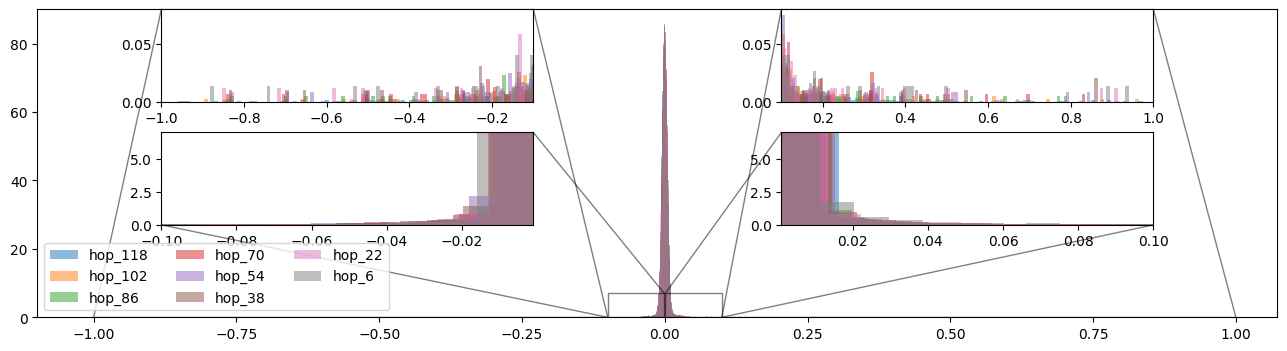

In [64]:
plot_id = np.arange(2,len(hop_),8)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig,ax = plt.subplots(1,1,figsize=(16,4))
for i in reversed(range(len(plot_id))):
    plt.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(),1000,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))



axins = ax.inset_axes([0.1, 0.7, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins, edgecolor="black")

# Create the second inset (-0.1, -0.001)
axins2 = ax.inset_axes([0.1, 0.3, 0.3, 0.3], xlim=(-0.1, -0.001), ylim=(0, 7))
ax.indicate_inset_zoom(axins2, edgecolor="black")

# Create the third inset (0.001, 0.1)
axins3 = ax.inset_axes([0.6, 0.3, 0.3, 0.3], xlim=(0.001, 0.1), ylim=(0, 7))
ax.indicate_inset_zoom(axins3, edgecolor="black")

# Create the fourth inset (0.1, 1)
axins4 = ax.inset_axes([0.6, 0.7, 0.3, 0.3], xlim=(0.1, 1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins4, edgecolor="black")


for i in (range(len(plot_id))):
        axins.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200,alpha=0.5,density=True,color=colors[i])
        axins3.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
plt.legend(loc='lower left', ncols=3)

In [18]:
print('mean')
for reg in list(stats_per_region['mean'].keys()):
    print("test hypothesis (mean) global and ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_global['mean']['mean']))
print('std')
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (std) global and ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_global['std']['mean']))

mean
test hypothesis (mean) global and  :0.02 : PearsonRResult(statistic=0.284156391684105, pvalue=0.024007940813225506)
test hypothesis (mean) global and  0.02:0.04 : PearsonRResult(statistic=0.10072084741052842, pvalue=0.4321965766601945)
test hypothesis (mean) global and  0.04:0.08 : PearsonRResult(statistic=0.4628325226894439, pvalue=0.00013378523602827855)
test hypothesis (mean) global and  0.08:0.2 : PearsonRResult(statistic=0.0524475286921305, pvalue=0.6831016324242807)
test hypothesis (mean) global and  0.2:0.6 : PearsonRResult(statistic=0.8337086860134945, pvalue=2.247000073378637e-17)
test hypothesis (mean) global and  0.6: : PearsonRResult(statistic=0.47427604827798453, pvalue=8.61019805503512e-05)
std
test hypothesis (std) global and  :0.02 : PearsonRResult(statistic=0.649747519765119, pvalue=8.329635226889146e-09)
test hypothesis (std) global and  0.02:0.04 : PearsonRResult(statistic=-0.1674655294089297, pvalue=0.18955881530732566)
test hypothesis (std) global and  0.04:0.

In [66]:
stats.pearsonr(stats_global['std']['mean'], stats_global['kurtosis']['mean'])

PearsonRResult(statistic=-0.10067135594131855, pvalue=0.43242397416084655)

In [67]:
stats.pearsonr(stats_global['mean']['mean'], stats_global['skewness']['mean'])

PearsonRResult(statistic=0.7044037135373585, pvalue=1.1808820394949186e-10)

In [74]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = {}
    zcr_list['NAA']['mean'] = list(zcr_['NAA']['mean'])
    zcr_list['NAA']['std'] = list(zcr_['NAA']['std'])
    zcr_list['GABA'] = {}
    zcr_list['GABA']['mean'] = list(zcr_['GABA']['mean'])
    zcr_list['GABA']['std'] = list(zcr_['GABA']['std'])
    zcr_list['Glx'] = {}
    zcr_list['Glx']['mean'] = list(zcr_['Glx']['mean'])
    zcr_list['Glx']['std'] = list(zcr_['Glx']['std'])
    with open("quantitative_metrics_with_noise_hop_variation_mfft_512.txt", "w") as f:
        f.write("fwhm_hop=")
        f.write(json.dumps(fwhm_hop))
        f.write('\n')
        f.write("fwhm_hop_real=")
        f.write(json.dumps(fwhm_hop_real))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("max_sec=")
        f.write(json.dumps(max_sec))
        f.write('\n')
        f.write("qntty_percent_regions=")
        f.write(json.dumps(qntty_percent_regions))
        f.write('\n')
        f.write("qntty_absolute_regions=")
        f.write(json.dumps(qntty_absolute_regions))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))